In [1]:
import torch
import numpy as np
import pandas as pd
import codecs
import re
import nltk
import random

from nltk.stem import WordNetLemmatizer

from random import shuffle

from collections import Counter

from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

from torch import tensor
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset

from scipy.stats import entropy


# Parameters

In [2]:
# Number of recognized words you put in input
nb_input = 100 #8414 max

# Number of classe, constant
nb_output = 6

# Number of hidden layers
nb_hidd_lay = 5
hidden_size = 10

# Learning rate
lr = 0.001

# Number of epochs
nb_epochs = 10

# Random seed, don't change it if you don't know what it is
random_seed = 42

nb_batchs = 16

# How many percent of your data do you use as training set
devLine = 0.7

use_cuda = torch.cuda.is_available()

In [3]:
def seeding_random():
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    if use_cuda:
        torch.cuda.manual_seed_all(random_seed)
        torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.deterministic=True

## Dataloader implementation

In [4]:
class QuestionDataset(Dataset):
    
    # Special constructor
    # | nb_most_commons can either be the number of most common words you
    # | want to work with, OR a list of word you want to work with
    # If nb_most_commons == -1, then all word will count
    
    def __init__(self, train_data, nb_most_commons=-1):
        questions = []
        labels = []

        # Black list
        black_list = '\'`[@_!#$%^&*()<>?/\|}{~:]'

        for string in train_data:
            question_str = []
            for x in string.split()[1:]:
                s = ""
                for c in x:
                    if not c in black_list:
                        s += c
                if not s == "":
                    question_str.append(s.lower())
            labels.append(string.split()[0])
            questions.append(question_str)


        if isinstance(nb_most_commons, int):
            # Vocabulary of unique words
            data = []
            for q in questions:
                for w in q:
                    data.append(w)
            
            
            if nb_most_commons == -1:
                most_commons_words = Counter(data).most_common(len(data))
            else:
                most_commons_words = Counter(data).most_common(nb_most_commons)
            
            self.word_list = list([x[0] for x in most_commons_words])
            self.word_list.append('<bos>')
            self.word_list.append('<eos>')
            self.word_list.append('<unk>')
        elif isinstance(nb_most_commons, list):
            self.word_list = nb_most_commons
        else:
            print("ERROR: second arg is neither an int, nor a list")
            
        words_array = np.array(self.word_list)
        
        # Add tags <bos> and <eos> to questions
        for q in questions:
            if q[0] != '<bos>' :
                q.insert(0, '<bos>')
                q.append('<eos>')

        # Integer encoding with OneHotEncoder
        words_tre = words_array.reshape(len(words_array),1)
        one_hot_encoder = OneHotEncoder(sparse=False)
        onehot_encoded = one_hot_encoder.fit_transform(words_tre)
        # Creating a dictionnary of word and its one hot array
        self.words_onehoted = {}
        for i in range(0, len(words_array)):
            self.words_onehoted[self.word_list[i]] = onehot_encoded[i]

        # One hot categories
        self.categories_onehoted = {}
        self.categories_onehoted['ABBR'] = 0 # Abbreviation
        self.categories_onehoted['ENTY'] = 1 # Entity
        self.categories_onehoted['DESC'] = 2 # Description
        self.categories_onehoted['HUM']  = 3 # Human
        self.categories_onehoted['LOC']  = 4 # Location
        self.categories_onehoted['NUM']  = 5 # Numeric

        self.batch_data = []
        for num_question in range(len(questions)):
            # Construction of question_onehot list.
            question_onehot = [self.get_onehot_word(word) for word in questions[num_question]]

            # Construction of category_onehot.
            category = labels[num_question].partition(':')[0]
            category_onehot = self.get_onehot_category(category)
            self.batch_data.append([(question_onehot), (category_onehot)])

        
    
    # Function to get the corresponding one hot list for a category.
    def get_onehot_category(self, category):
        return self.categories_onehoted[category]


    # Function to get the corresponding one hot list for a word.
    def get_onehot_word(self, word):
        if word in self.words_onehoted:
            return list(self.words_onehoted[word])
        else:
            return list(self.words_onehoted['<unk>'])

    

                
    def __len__(self):
        return len(self.batch_data)

    def __getitem__(self, idx):
        seeding_random()
        return self.batch_data[idx]
    
def pad_collate(batch):
    max_length = max([len(q[0]) for q in batch])

    inputs = torch.FloatTensor([[[0. for _ in range(len(x[0][0]))] for i in range(max_length-len(x[0]))]+x[0] for x in batch])
    outputs = torch.LongTensor([x[1] for x in batch])
    
    return inputs, outputs
    

In [5]:

seeding_random()

# Encoding in windows-1252, utf-8 generate error on some char
file = codecs.open("train_all.label", "r+","windows-1252")
data = []
for line in file.readlines():
    data.append(line)
train_data = data[:round(len(data)*devLine)]
dev_data = data[round(len(data)*devLine):]

print("Création training set...")
training_set = QuestionDataset(data, nb_input-3)

print("Done!")

print("Création dev set...")
dev_set = QuestionDataset(data, training_set.word_list)
seeding_random()

print("Done!")

print("Création test set...")
file = codecs.open("TREC_test.label", "r+","windows-1252")
data = []
for line in file.readlines():
    data.append(line)
test_set = QuestionDataset(data, training_set.word_list)
seeding_random()

# Création du DataLoader
dataloader_args = dict(shuffle=True, batch_size=nb_batchs, num_workers=1,
                       pin_memory=True, worker_init_fn=seeding_random(), collate_fn=pad_collate)
seeding_random()

train_loader = dataloader.DataLoader(training_set, **dataloader_args)
seeding_random()

dataloader_args_notshuffle = dict(shuffle=False, batch_size=nb_batchs, num_workers=1,
                       pin_memory=True, worker_init_fn=seeding_random(), collate_fn=pad_collate)

dev_loader = dataloader.DataLoader(dev_set, **dataloader_args)
seeding_random()

test_loader = dataloader.DataLoader(test_set, **dataloader_args_notshuffle)
seeding_random()
print("Done!")

print("List of word used:")
print(training_set.word_list)


Création training set...
Done!
Création dev set...
Done!
Création test set...
Done!
List of word used:
['the', 'what', 'is', 'of', 'in', 'a', 'how', 's', 'was', 'who', 'to', ',', 'are', 'for', 'and', 'did', 'does', 'do', 'name', 'on', 'many', 'where', 'i', 'first', 'you', 'can', 'when', 'from', 'world', 'which', 'that', 'as', 'city', 'country', 'u.s.', 'most', 'with', 'by', 'has', 'an', '.', 'have', 'it', 'why', 'find', 'there', 'people', 'get', 'called', 'be', 'were', 'state', 'year', 'mean', 'his', 'american', 'at', 'president', 'two', 'largest', 'fear', 'war', 'new', 'its', 'much', 'between', 'long', 'origin', 'made', 'word', 'about', 'company', 'kind', 'film', 'known', 'movie', 'game', 'day', 'live', 'or', 'tv', 'your', 'take', 'one', 'famous', 'stand', 'used', 'all', 'only', 'book', 'best', 'man', 'john', 'color', 'their', 'he', 'invented', '<bos>', '<eos>', '<unk>']


# RNN implementation
Using ReLU, and CrossEntropy

In [6]:
class RNN(nn.Module):
    def __init__(self, nb_inputs, nb_layers, nb_neurons, nb_outputs, learning_rate):
        super(RNN, self).__init__()
        
        # Applying RNN layer, and softmax then
        self.rnn = nn.RNN(input_size=nb_inputs, num_layers=nb_layers,
                   hidden_size=nb_neurons, dropout=0., batch_first=True, nonlinearity='relu')
        self.inter = nn.Linear(nb_neurons, nb_outputs)
        self.sm = nn.Softmax(dim=1)
        
        # Other usefull variables here
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.input_dim = nb_inputs
        self.output_dim = nb_output
        self.nb_layers = nb_layers
        self.nb_neurons = nb_neurons
        
    def forward(self, inputs):
        h0 = torch.zeros(self.nb_layers, inputs.size(0), self.nb_neurons)
        if use_cuda:
            h0 = h0.to("cuda")
        x, hn = self.rnn(inputs, h0)
        
        x = self.inter(hn[0])
        #print(x)
        #x = tensor([list(i[-1]) for i in x])
        #print(x)
        x = self.sm(x)
        return x

# End of the class RNN

#TODO
def getEntropies(rnn, batch_list):
    entropy_list = []
    #value, counts = np.unique(out, return_counts=True)
    #entropy_list.append(entropy(out, base=None))
    return [-1]


# return (rightAnswer, falseAnswer, entropy_list)
def getEfficience(rnn, batch_list) :
    total_correct = 0
    total = 0
    device = torch.device("cuda" if use_cuda else "cpu")
    for (data, target) in batch_list :
        data, target = data.to(device), target.to(device)
        out = rnn(data).data
        
        _, predicted = torch.max(out.data, dim=1)
        correct = (predicted == target).sum().item()
        total_correct += correct
        total += target.size(0)

    return (total_correct, total-total_correct)

# Now let's define learn(), which learn a RNN some data
def learn(rnn, data_loader, num_epochs=1):
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        rnn.cuda(device)
    
    # Preparing
    rnn.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    
    best_rnn = rnn
    eff = getEfficience(rnn, dev_loader)
    total = sum(eff)
    max_acc_dev = eff[0]/total
    pos_best_rnn = 0;

    for epoch in range(num_epochs):
        total_correct = 0
        total_target = 0
        
        for batch_idx, (data, target) in enumerate(data_loader):
            #rnn.train()
            seeding_random()
            data, target = data.to(device), target.to(device)
            
            output = rnn(data)
            #print(output)
            #print(target)
            loss = criterion(output, target)
            rnn.optimizer.zero_grad()
            loss.backward()
            rnn.optimizer.step()
            
            # Get the Accuracy
            
            _, predicted = torch.max(output.data, dim=1)
            correct = (predicted == target).sum().item()
            total_correct += correct
            total_target += target.size(0)
            
            # Print the progress
            if batch_idx % 500 == 0 or batch_idx % 500 == 1 or batch_idx == len(data_loader)-1:
                print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\t Loss: {:.6f}\t Accuracy: {}'.format(
                    epoch+1,
                    num_epochs,
                    batch_idx * len(data), 
                    len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), 
                    loss.data.item(),
                    (total_correct / total_target) * 100),
                    end='')
                losses.append(loss.data.item())
                
        print()
        eff = getEfficience(rnn, dev_loader)
        acc_dev = eff[0]/total *100
        if acc_dev > max_acc_dev:
            max_acc_dev = acc_dev
            best_rnn = rnn
            pos_best_rnn = epoch
        
        print("Dev set: accuracy: " + str(acc_dev) + "% | max acc: " + str(max_acc_dev)+"%")
        print()
    rnn = best_rnn
    # Return losses list, you can print them later if you want
    return {"losses":losses, "pos_best":pos_best_rnn}


# Using the RNN

In [7]:
seeding_random()

rnn = RNN(nb_inputs = nb_input, nb_layers=nb_hidd_lay,
          nb_neurons=hidden_size, nb_outputs=nb_output, learning_rate=lr)
if use_cuda:
    rnn = rnn.to("cuda")

seeding_random()


with torch.enable_grad():
    job = learn(rnn, train_loader, nb_epochs)
    losses = job["losses"]
    pos_best_rnn = job["pos_best"]
    print("Done :)")

 Train Epoch: 1/10 [11580/15452 (100%)]	 Loss: 1.656912	 Accuracy: 26.32021744757964
Dev set: accuracy: 38.51928552938131% | max acc: 38.51928552938131%

 Train Epoch: 2/10 [11580/15452 (100%)]	 Loss: 1.649046	 Accuracy: 43.96841832772457
Dev set: accuracy: 49.11985503494693% | max acc: 49.11985503494693%

 Train Epoch: 3/10 [11580/15452 (100%)]	 Loss: 1.620689	 Accuracy: 49.57934247993787
Dev set: accuracy: 51.11312451462594% | max acc: 51.11312451462594%

 Train Epoch: 4/10 [11580/15452 (100%)]	 Loss: 1.568035	 Accuracy: 52.536888428682374
Dev set: accuracy: 56.71757701268444% | max acc: 56.71757701268444%

 Train Epoch: 5/10 [11580/15452 (100%)]	 Loss: 1.524307	 Accuracy: 57.733626714988354
Dev set: accuracy: 59.616878074035725% | max acc: 59.616878074035725%

 Train Epoch: 6/10 [11580/15452 (100%)]	 Loss: 1.502626	 Accuracy: 59.68159461558374
Dev set: accuracy: 61.241263266891025% | max acc: 61.241263266891025%

 Train Epoch: 7/10 [11580/15452 (100%)]	 Loss: 1.489106	 Accuracy: 62.

## Error curve

interactive(children=(IntSlider(value=5, description='smooth', max=500, min=5, step=2), Output()), _dom_classe…

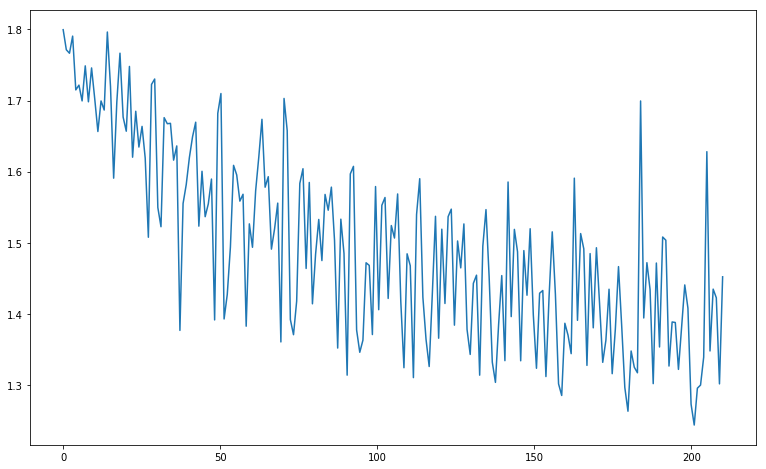

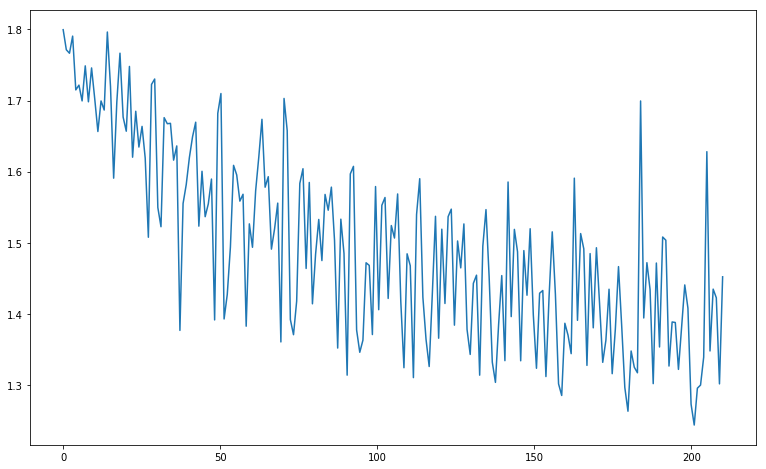

In [10]:
from scipy.signal import savgol_filter
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


def update_losses(smooth=1):
    x = np.linspace(0, len(losses), len(losses))
    fig = plt.figure(figsize=(13, 8)) 
    ax = fig.add_subplot(1,1,1)
    cnn_line, = ax.plot(x, losses)
    cnn_line.set_ydata(savgol_filter(losses, smooth, 3))
    
interact(update_losses, smooth=(5, 500, 2));


# Analysis on test set

In [9]:
rnn.eval()

seeding_random()

final_results = getEfficience(rnn, train_loader)
total = sum(final_results)

correct_train = final_results[0]/total*100
false_train = final_results[1]/total*100

print("Congratulations!")
print("On the training set:")
print("Corrects: " + str(correct_train) + "%")
print("False:    " + str(false_train) + "%")
print()

seeding_random()

final_results = getEfficience(rnn, dev_loader)
total = sum(final_results)

correct_dev = final_results[0]/total*100
false_dev = final_results[1]/total*100

print("Congratulations!")
print("On the dev set:")
print("Corrects: " + str(correct_dev) + "%")
print("False:    " + str(false_dev) + "%")
print()

seeding_random()

final_results_test = getEfficience(rnn, test_loader)
total = sum(final_results_test)

correct_test = final_results_test[0]/total*100
false_test = final_results_test[1]/total*100

entropy_list = getEntropies(rnn, test_loader)
mean_entropies = sum(entropy_list)/len(entropy_list)

#Entropy mean might be near to zero

print("On the test set:")
print("Moyenne des entropies: " + str(mean_entropies))
print("Corrects: " + str(correct_test) + "%")
print("False:    " + str(false_test) + "%")

mean_entropies = -1
print()
print("A présent, tu peux copier-coller ça dans le doc sur le drive :)")
print(str(nb_input)+"\t"+str(lr)+"\t"+str(nb_epochs)+"\t"+str(nb_hidd_lay)
      +"\t"+str(hidden_size)+"\t"+str(nb_batchs)+"\t\t"+str(mean_entropies)+"\t"+str(pos_best_rnn)
      +"\t"+str(correct_train)+"%\t"+str(correct_dev)+"%\t"+str(correct_test)+"%")
print()



Congratulations!
On the training set:
Corrects: 68.45068599534041%
False:    31.54931400465959%

Congratulations!
On the dev set:
Corrects: 68.45068599534041%
False:    31.54931400465959%

On the test set:
Moyenne des entropies: -1.0
Corrects: 70.39999999999999%
False:    29.599999999999998%

A présent, tu peux copier-coller ça dans le doc sur le drive :)
100	0.001	10	5	10	16		-1	9	68.45068599534041%	68.45068599534041%	70.39999999999999%

